In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import KFold


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

SEED=42
cpu=-1
datasetFolder=os.path.dirname(os.path.dirname(os.getcwd()))

def predict_score(model,x_train,y_train,x_test,y_test,name):
    model.fit(x_train,y_train)
    best_pipe=model.best_estimator_
    poly=best_pipe.named_steps["polynomial_features"]
    poly_features=poly.get_feature_names_out(list(x_train.columns))
    selector=best_pipe.named_steps["feature_selection"]
    select_indices=selector.get_support(1)
    select_features=poly_features[select_indices]
    y_predict=model.predict(x_test)
    f1=f1_score(y_test,y_predict)
    auc_score=roc_auc_score(y_test,y_predict)
    a=1
    return f1,auc_score,select_features
    
def baseDataSet(x_train,x_test):
    factors=["dit_x","fanin_x","fanout_x","lcc_x","lcom*_x","loc_x","noc_x","rfc_x","innerClassesQty_x","totalFieldsQty_x","totalMethodsQty_x","wmc_x"]
    new_x_train=x_train[factors]
    new_x_test=x_test[factors]
    return new_x_train,new_x_test


def baseVersionDataSet(x_train,x_test):
    factors=["dit_x","fanin_x","fanout_x","lcc_x","lcom*_x","loc_x","noc_x","rfc_x","innerClassesQty_x","totalFieldsQty_x","totalMethodsQty_x","wmc_x","dit_y","fanin_y","fanout_y","lcc_y","lcom*_y","loc_y","noc_y","rfc_y","innerClassesQty_y","totalFieldsQty_y","totalMethodsQty_y","wmc_y"]
    new_x_train=x_train[factors]
    new_x_test=x_test[factors]
    return new_x_train,new_x_test


def overSampling(x_train,y_train):
    x_sampling,y_sampling=SMOTE(sampling_strategy=0.2,random_state=SEED).fit_resample(x_train,y_train)
    return x_sampling,y_sampling

In [2]:
GodClassFile=os.path.join(datasetFolder,"version1yeardataset2\\GodClass.csv")
factors=["dit","fanin","fanout","lcc","lcom*","loc","noc","rfc","innerClassesQty","totalFieldsQty","totalMethodsQty","wmc"]
factors2=["dit_x","fanin_x","fanout_x","lcc_x","lcom*_x","loc_x","noc_x","rfc_x","innerClassesQty_x","totalFieldsQty_x","totalMethodsQty_x","wmc_x","dit_y","fanin_y","fanout_y","lcc_y","lcom*_y","loc_y","noc_y","rfc_y","innerClassesQty_y","totalFieldsQty_y","totalMethodsQty_y","wmc_y","GodClass"]
df=pd.read_csv(GodClassFile,encoding_errors="replace")
df=df[factors2]
df=df.dropna(how="any")
for factor in factors:
    df[factor+"_y"]=df[factor+"_x"]-df[factor+"_y"]
x=df.drop(columns=["GodClass"])
y=df[["GodClass"]].values.ravel()
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=SEED)
x_sampling,y_sampling=overSampling(x_train,y_train)

x_base_train,x_base_test=baseDataSet(x_sampling,x_test)
y_base_train=y_sampling
y_base_test=y_test
base_score={"f1":[],"auc":[],"feature":[]}
print(x_base_train.columns)

x_baseVersion_train,x_baseVersion_test=baseVersionDataSet(x_sampling,x_test)
y_baseVersion_train=y_sampling
y_baseVersion_test=y_test
baseVersion_score={"f1":[],"auc":[],"feature":[]}
print(x_baseVersion_train.columns)

Index(['dit_x', 'fanin_x', 'fanout_x', 'lcc_x', 'lcom*_x', 'loc_x', 'noc_x',
       'rfc_x', 'innerClassesQty_x', 'totalFieldsQty_x', 'totalMethodsQty_x',
       'wmc_x'],
      dtype='object')
Index(['dit_x', 'fanin_x', 'fanout_x', 'lcc_x', 'lcom*_x', 'loc_x', 'noc_x',
       'rfc_x', 'innerClassesQty_x', 'totalFieldsQty_x', 'totalMethodsQty_x',
       'wmc_x', 'dit_y', 'fanin_y', 'fanout_y', 'lcc_y', 'lcom*_y', 'loc_y',
       'noc_y', 'rfc_y', 'innerClassesQty_y', 'totalFieldsQty_y',
       'totalMethodsQty_y', 'wmc_y'],
      dtype='object')


In [3]:
name="DT"
DT_prameter={
    "classifier__criterion":["gini","entropy"],
    "classifier__max_depth":list(range(1,11)),
    "classifier__min_samples_split":list(range(2,21)),
    "classifier__min_samples_leaf":list(range(1,11)),
    "classifier__max_features":["sqrt","log2",None]
    }

k_range=np.arange(1,11,1)
for i in k_range:
    pipline=Pipeline([
        ("polynomial_features",PolynomialFeatures(degree=2)),
        ("minmaxscaler",MinMaxScaler()),
        ("feature_selection",SelectKBest(score_func=f_classif,k=i)),
        ("classifier",DecisionTreeClassifier(random_state=SEED))
    ])
    DT_model=RandomizedSearchCV(pipline, param_distributions=DT_prameter,cv=KFold(n_splits=10,shuffle=True,random_state=SEED),random_state=SEED,n_jobs=cpu,scoring="f1")
    print(str(i))
    f1_base,auc_base,feature_base=predict_score(DT_model,x_base_train,y_base_train,x_base_test,y_base_test,name)
    base_score["f1"].append(f1_base)
    base_score["auc"].append(auc_base)
    base_score["feature"].append(feature_base)
    
    f1_baseVersion,auc_baseVersion,feature_baseVersion=predict_score(DT_model,x_baseVersion_train,y_baseVersion_train,x_baseVersion_test,y_baseVersion_test,name)
    baseVersion_score["f1"].append(f1_baseVersion)
    baseVersion_score["auc"].append(auc_baseVersion)
    baseVersion_score["feature"].append(feature_baseVersion)


1


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


2


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


3


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


4


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


5


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


6


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


7


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


8


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


9


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


10


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


base
f1 :  0.08403361344537816
auc_score :  0.6275663806958371
Index(['dit_x', 'fanin_x', 'fanout_x', 'rfc_x', 'wmc_x'], dtype='object')

addMetrics
f1 :  0.10569105691056911
auc_score :  0.6700273898182312
Index(['dit_x', 'fanout_x', 'rfc_x', 'BOvR_x', 'BUR_x'], dtype='object')

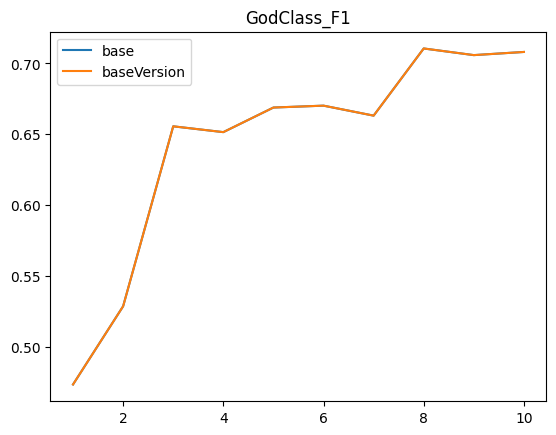

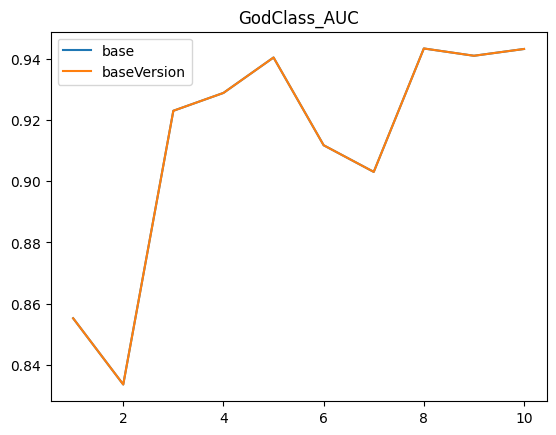

In [4]:
import matplotlib.pyplot as plt

x=k_range
plt.title("GodClass_F1")
plt.plot(x,base_score["f1"],label="base")
plt.plot(x,baseVersion_score["f1"],label="baseVersion")
plt.legend()
plt.show()

plt.title("GodClass_AUC")
plt.plot(x,base_score["auc"],label="base")
plt.plot(x,baseVersion_score["auc"],label="baseVersion")
plt.legend()
plt.show()

In [5]:
print("base : ",base_score)
print("baseVersion : ",baseVersion_score)

base :  {'f1': [0.4731774415405777, 0.5284280936454849, 0.6555740432612313, 0.6514657980456026, 0.6688417618270799, 0.6701754385964912, 0.6631205673758865, 0.7105719237435009, 0.7058823529411765, 0.7081174438687392], 'auc': [0.855168606875444, 0.8334852708094224, 0.9231032409684647, 0.9289501011094715, 0.9405530961359785, 0.9118194239492813, 0.9030944963655244, 0.9435043996283543, 0.9411182161010002, 0.9433404383232223], 'feature': [array(['rfc_x'], dtype=object), array(['rfc_x', 'lcom*_x rfc_x'], dtype=object), array(['rfc_x', 'lcom*_x rfc_x', 'lcom*_x wmc_x'], dtype=object), array(['rfc_x', 'fanout_x lcom*_x', 'lcom*_x rfc_x', 'lcom*_x wmc_x'],
      dtype=object), array(['fanout_x', 'rfc_x', 'fanout_x lcom*_x', 'lcom*_x rfc_x',
       'lcom*_x wmc_x'], dtype=object), array(['fanout_x', 'rfc_x', 'fanout_x lcom*_x', 'lcom*_x rfc_x',
       'lcom*_x totalMethodsQty_x', 'lcom*_x wmc_x'], dtype=object), array(['fanout_x', 'rfc_x', 'fanout_x lcom*_x', 'lcom*_x^2',
       'lcom*_x rfc_x', 